# Texture Synthesis with CNNs in PyTorch

<a href="https://colab.research.google.com/github/trsvchn/deep-textures/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
import torch
import torch.optim as optim
from torchvision.transforms.functional import normalize

from PIL import Image as img
import matplotlib.pyplot as plt

from UNET import UNet, gram_loss, gram_loss_rotate
from UNET.utils import set_seed, set_device, prep_img, to_pil, MEAN, STD

import numpy as np
import sys

In [2]:
# gpu 연결 확인

import torch

print("current device : {}, device 0 : {} , is available : {} , torch version : {}"
      .format(torch.cuda.current_device(), torch.cuda.get_device_name(0) , torch.cuda.is_available() , torch.__version__))

current device : 0, device 0 : NVIDIA GeForce RTX 3060 Laptop GPU , is available : True , torch version : 2.0.1


In [3]:
# Uncomment if running from Colab
# !git clone https://github.com/trsvchn/deep-textures.git
# %cd deep-textures

Unofficial Reimplementation of **"Texture Synthesis Using Convolutional Neural Networks"** in PyTorch
(Gatys et al. 2015) (http://arxiv.org/abs/1505.07376)

## Prepare Data

In [4]:
from io import BytesIO
from urllib.request import urlopen

# Get the example image from the official repo
# IMG = "https://raw.githubusercontent.com/leongatys/DeepTextures/master/Images/pebbles.jpg" # url 경우
# IMG = "./testingTextures/12.JPG" # jpg 일 경우
# IMG = "./testingTextures/txt09.png" # png 일 경우
IMG1 = "./testingTextures/capture/draw-51.bmp"  # bmp 경우
IMG2 = "./testingTextures/capture/draw-54.bmp"  # bmp 경우

(600, 600)


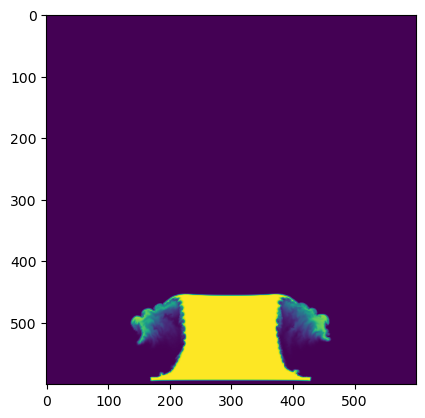

In [5]:
# Take a look
#texture = Image.open(BytesIO(urlopen(IMG).read()))
img1 = img.open(IMG1) # 이미지 파일 메타 정보 확인 -> 이미지 객체 반환
img1 = img1.convert('RGB')

img2 = img.open(IMG2) # 이미지 파일 메타 정보 확인 -> 이미지 객체 반환
img2 = img2.convert('RGB')

print(np.shape(img2))

plt.imshow(img1)  # imshow는 원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림 , colormap 설정가능
plt.imshow(img2)

In [6]:
img_np = np.array(img1, 'uint8')
print(np.shape(img_np))

np.set_printoptions(threshold=sys.maxsize)
print(img_np[550])

(600, 600)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   1
   1   2   2   2   2   2   2   2   2   2   2   2   1   2   2   3  12  79
 173 221 239 250 254 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255

In [7]:
# # Save it (uncomment to save)
# texture.save("inputTexture.jpg")

## Using MSE
### Main Interpolation

In [8]:
# texture 이 bmp 이미지 -> 'L' 하나의 회색 이미

n_iters = 1000
# layers = ["conv1_1", "pool1", "pool2", "pool3", "pool4"]
# layers_weigths = [1e9] * len(layers)
log_every = 200
seed = 0


# Set device and a seed
device = set_device()
set_seed(seed)

# Init model
model = UNet().to(device)  # 레이어만 생성

model

UNet(
  (conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (

In [13]:
# Prepare texture data
target1 = prep_img(img1).to(device)
target2 = prep_img(img2).to(device)

target = torch.concatenate((target1,target2), axis=1)
# target = target.squeeze(0)

print(np.shape(target))

torch.Size([1, 2, 600, 600])


torch.Size([1, 1, 600, 600])


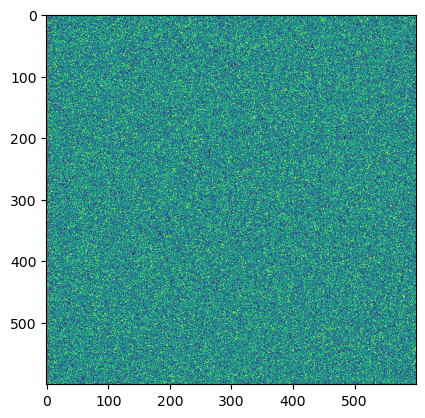

In [14]:
# Init input image
synth = torch.randint_like(target, 0, 256)
synth = synth.div(255)
synth = normalize(synth, MEAN, STD)
synth.requires_grad_(True)
# synth = synth.squeeze(0)

print(synth.shape)

# Show image
plt.imshow(to_pil(synth.squeeze(0)))    # dim=0 차원 축소
plt.show()

In [16]:
# Set optimizer
optimizer = optim.LBFGS(
    [synth],
    tolerance_grad=0.0,
    tolerance_change=0.0,
    line_search_fn="strong_wolfe",
)

# Get feature maps for the target texture
target_activations = [*model(target)]

target_activations

RuntimeError: Given groups=1, weight of size [521, 521, 3, 3], expected input[1, 512, 37, 37] to have 521 channels, but got 512 channels instead

In [12]:
prediction = model(target)

ValueError: expected 4D input (got 3D input)

In [ ]:
# Set optimizer
optimizer = optim.LBFGS(
    [synth],
    tolerance_grad=0.0,
    tolerance_change=0.0,
    line_search_fn="strong_wolfe",
)

# Get feature maps for the target texture
target_activations = [model(target)]

target_activations


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


0 3507041280.0


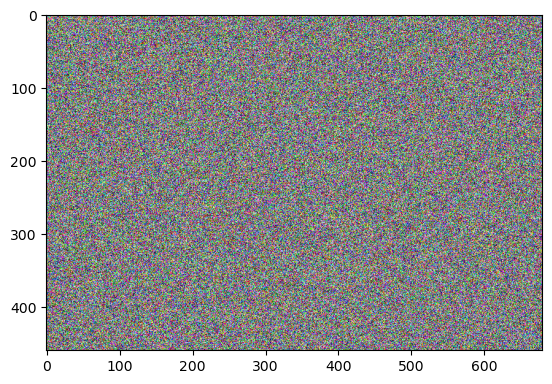

In [ ]:
iter_ = 0
while iter_ <= n_iters:

    def closure():
        global iter_

        optimizer.zero_grad()

        synth_activations = [*model(synth, layers)]

        assert len(synth_activations) == len(target_activations) == len(layers_weigths)
        
        # Compute loss for each activation
        losses = []
        for activations in zip(synth_activations, target_activations, layers_weigths):
            losses.append(gram_loss(*activations).unsqueeze(0))

        total_loss = torch.cat(losses).sum()
        total_loss.backward()

        if iter_ == 0 or iter_ % log_every == 0:
            # Print loss value
            print(iter_, total_loss.item())

            # Show image
            plt.imshow(to_pil(synth.squeeze(0)))
            plt.show()

        iter_ += 1

        return total_loss

    optimizer.step(closure)


# Save generated texture
to_pil(synth.squeeze()).save("outputTexture.png")

## Using Adam

In [ ]:
image = "pebbles.jpg"
img_size = 256
n_iters = 1000
layers = ["conv1_1", "pool1", "pool2", "pool3", "pool4"]
layers_weigths = [1e9] * len(layers)
log_every = 500
seed = 0 

# Set device and a seed
device = set_device()
set_seed(seed)

# Init model
model = vgg19().to(device)

# Prepare texture data
target = prep_img(image, img_size).to(device)

# Init input image
synth = torch.randint_like(target, 0, 256)
synth = synth.div(255)
synth = normalize(synth, MEAN, STD)
synth.requires_grad_(True)

# Set optimizer
optimizer = optim.Adam([synth], lr=0.1)

# Get feature maps for the target texture
target_activations = [*model(target, layers)]

for iter_ in range(1, n_iters + 1):
    optimizer.zero_grad()

    synth_activations = [*model(synth, layers)]

    assert len(synth_activations) == len(target_activations) == len(layers_weigths)

    losses = []
    for activations in zip(synth_activations, target_activations, layers_weigths):
        losses.append(gram_loss(*activations).unsqueeze(0))

    total_loss = torch.cat(losses).sum()
    total_loss.backward()

    if iter_ == 1 or iter_ % log_every == 0:
        print(iter_, total_loss.item())
        plt.imshow(to_pil(synth.squeeze(0)))
        plt.show()

    optimizer.step()


to_pil(synth.squeeze()).save("pebbles_gen_adam.png")

FileNotFoundError: [Errno 2] No such file or directory: 'pebbles.jpg'